# Yatırım Stratejileri için Borsa İstabul Hisse Fiyat Tahmini - METİN ILGAR MUTLU

**Bu tahmin sonuçları al-sat yapmak için değil borsa stratejileri oluşturmak için uygundur. Model ile kısa vadeli al-sat işlemleri mantıklı değildir. Maddi zararlara yol açabilir. Modeli al-sat aracı olarak kullanmak yerine indikatör olarak kullanılması daha uygundur. Model kullanılarak oluşan maddi zararlarlardan hiçbir sorumluluk kabul edilmemektedir.**

## Proje Özeti

Bu proje, Borsa İstanbul (BIST) hisse senetleri için tarihsel fiyat verilerini kullanarak gelecekteki fiyat hareketlerini tahmin eden ve yatırım stratejileri oluşturmaya yardımcı olan bir makine öğrenimi modelinin geliştirilmesini amaçlamaktadır. Proje, Yahoo Finance API üzerinden alınan verilerle makine öğrenme algoritmalarını kullanarak hisse senedi piyasasında yatırım stratejileri için öngörüler oluşturmaktadır. Bu öngörüleri uç kullanıcılar bir mobil uygulama üzerinden oluşturup kullanabilir.

## Temel Teknolojiler
- Python: Ana programlama dili
- Yahoo Finance API: Borsa İstanbul hisse senetlerine ait tarihsel veri setlerini çekmek
için
- Pandas ve NumPy: Veri analizi ve ön işleme işlemleri
- TensorFlow / Keras: Makine öğrenim modelleri oluşturma
- Scikit-Learn: Veri setinin bölünmesi ve ölçeklendirme işlemleri
- Matplotlib: Verilerin görselleştirilmesi

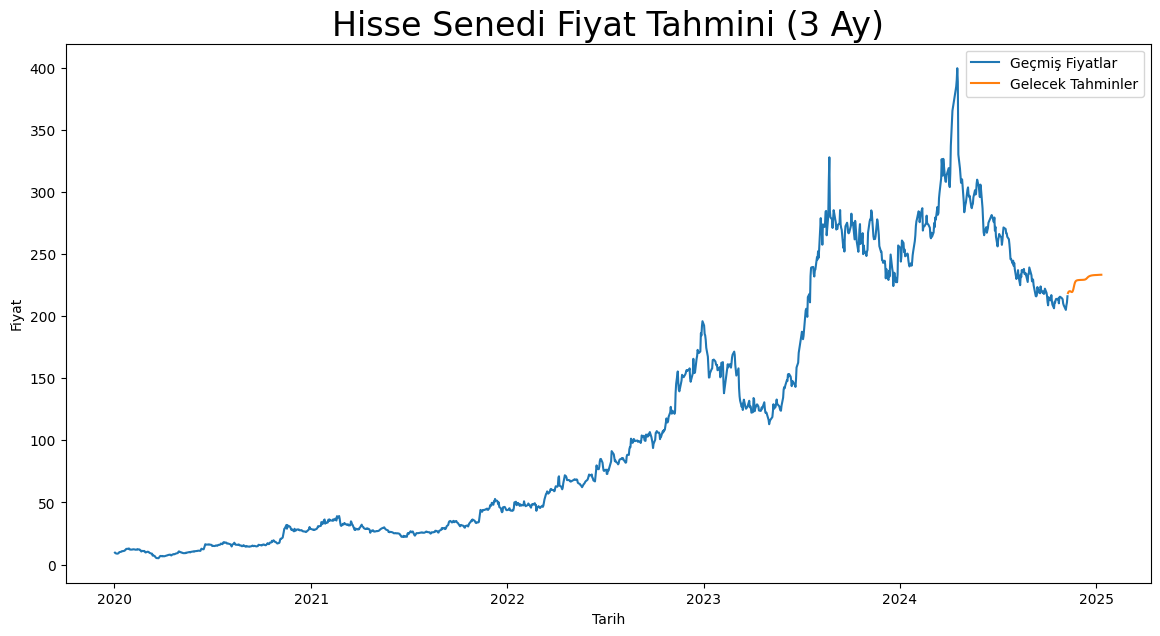

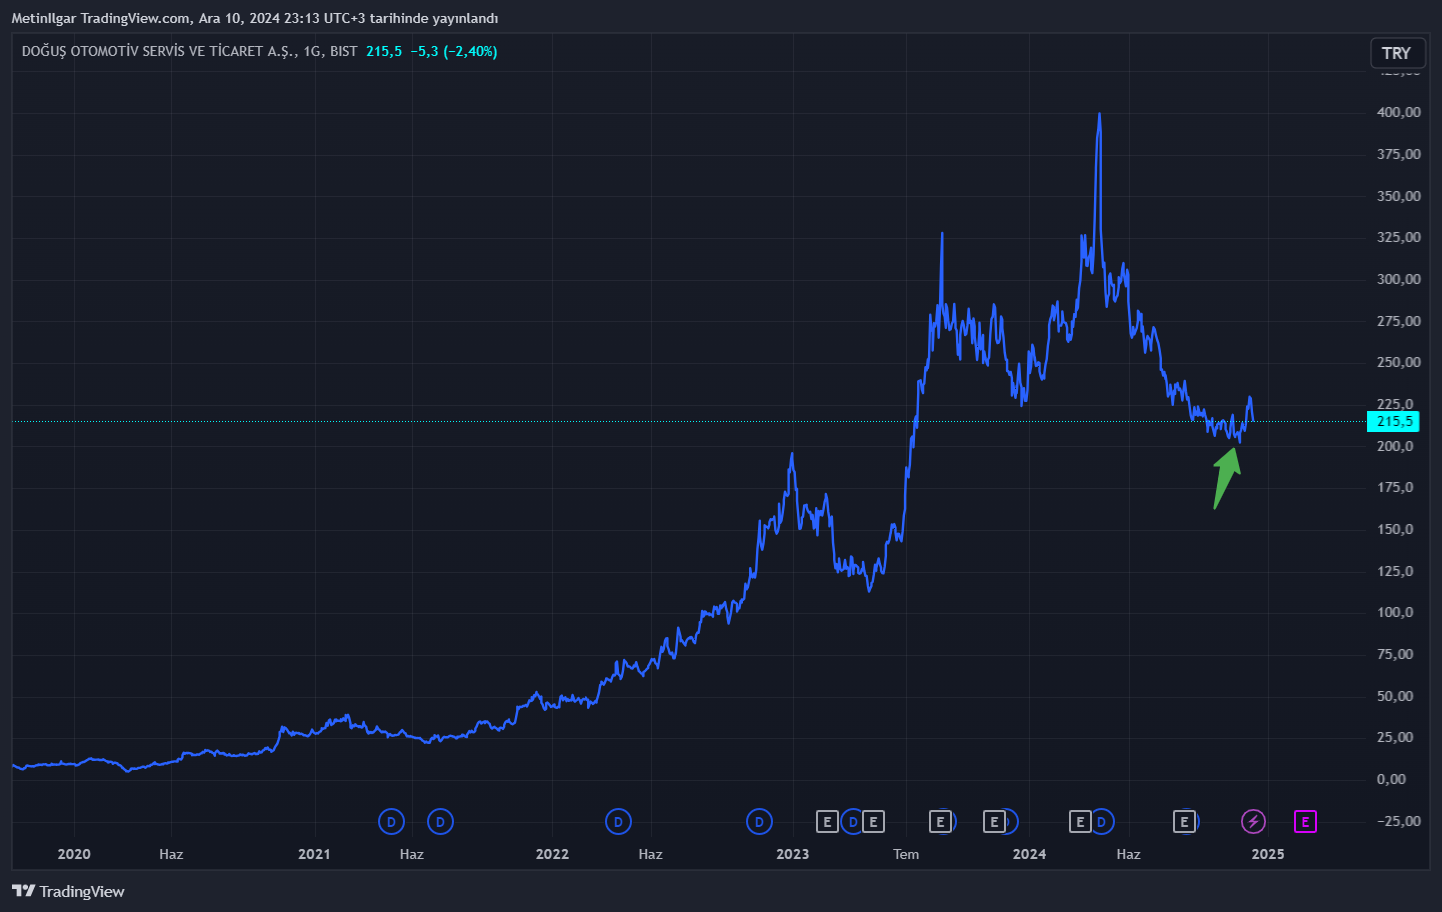

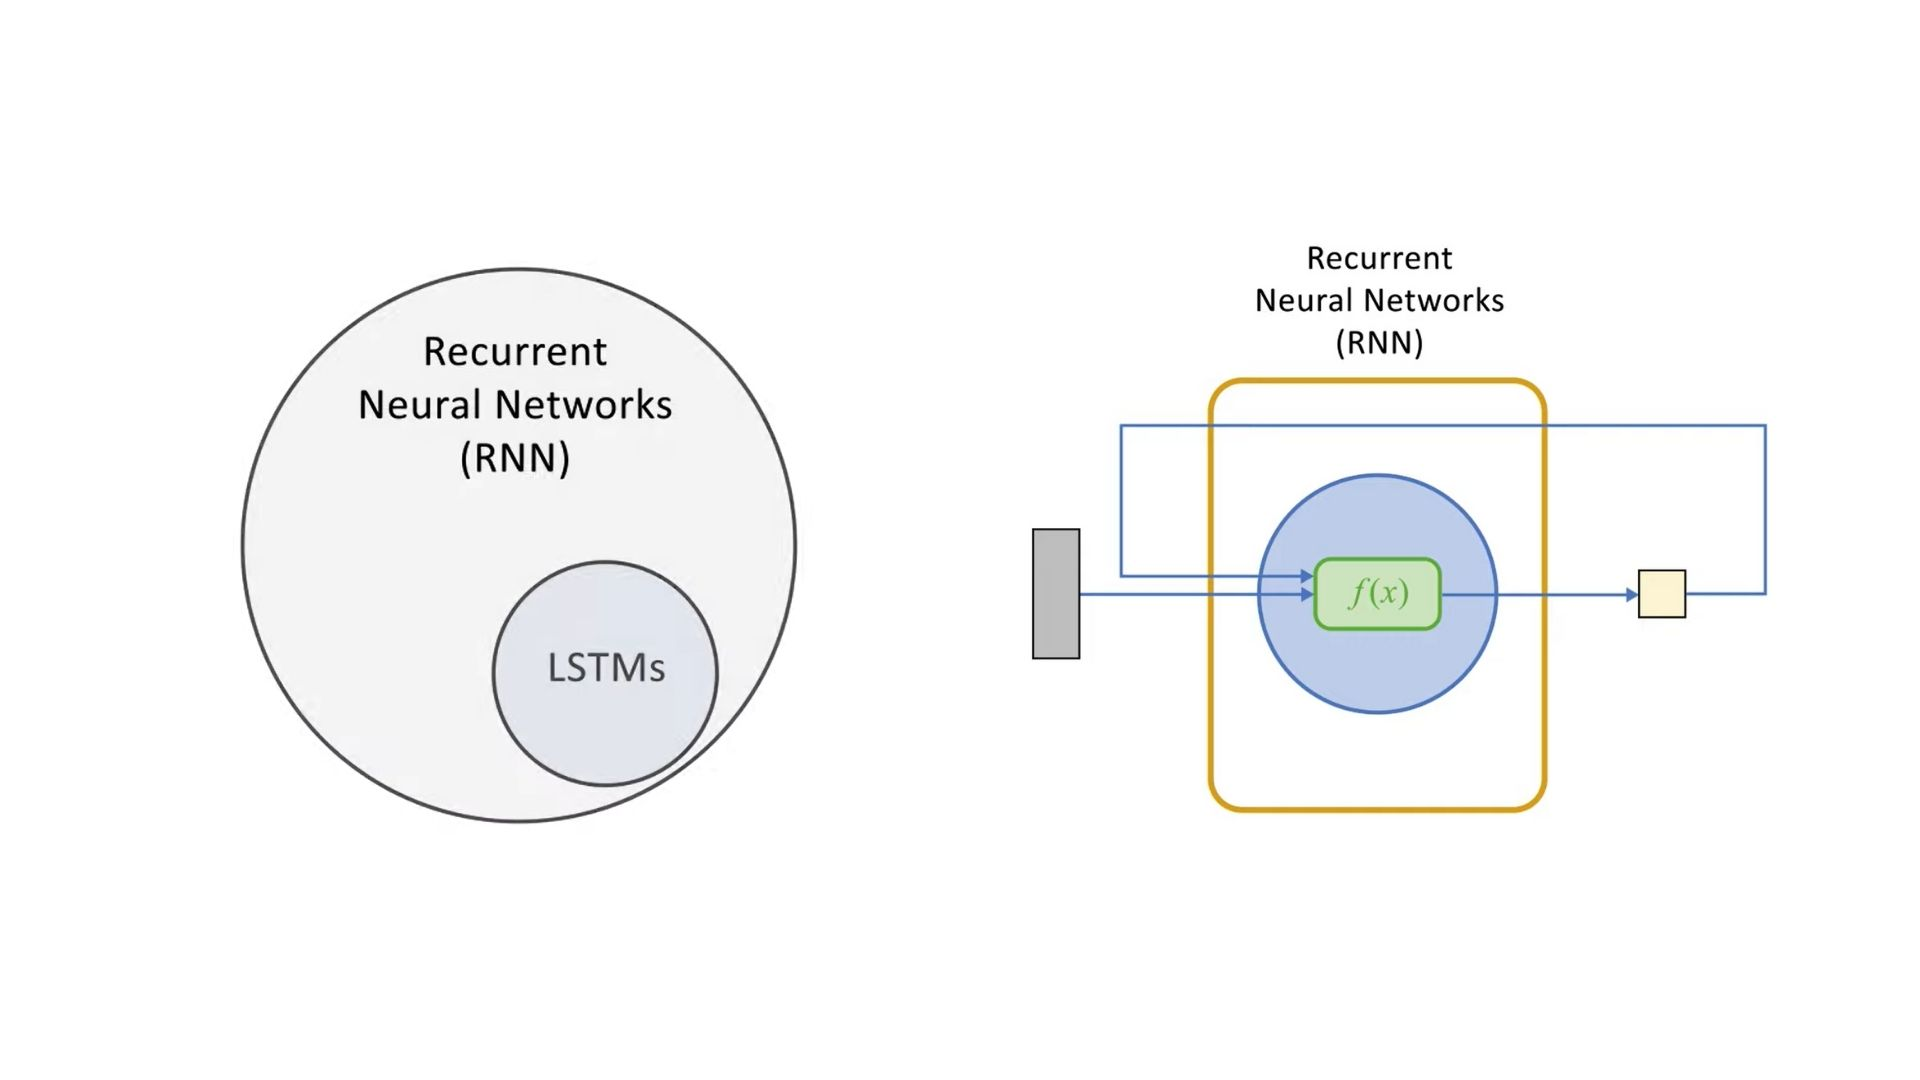

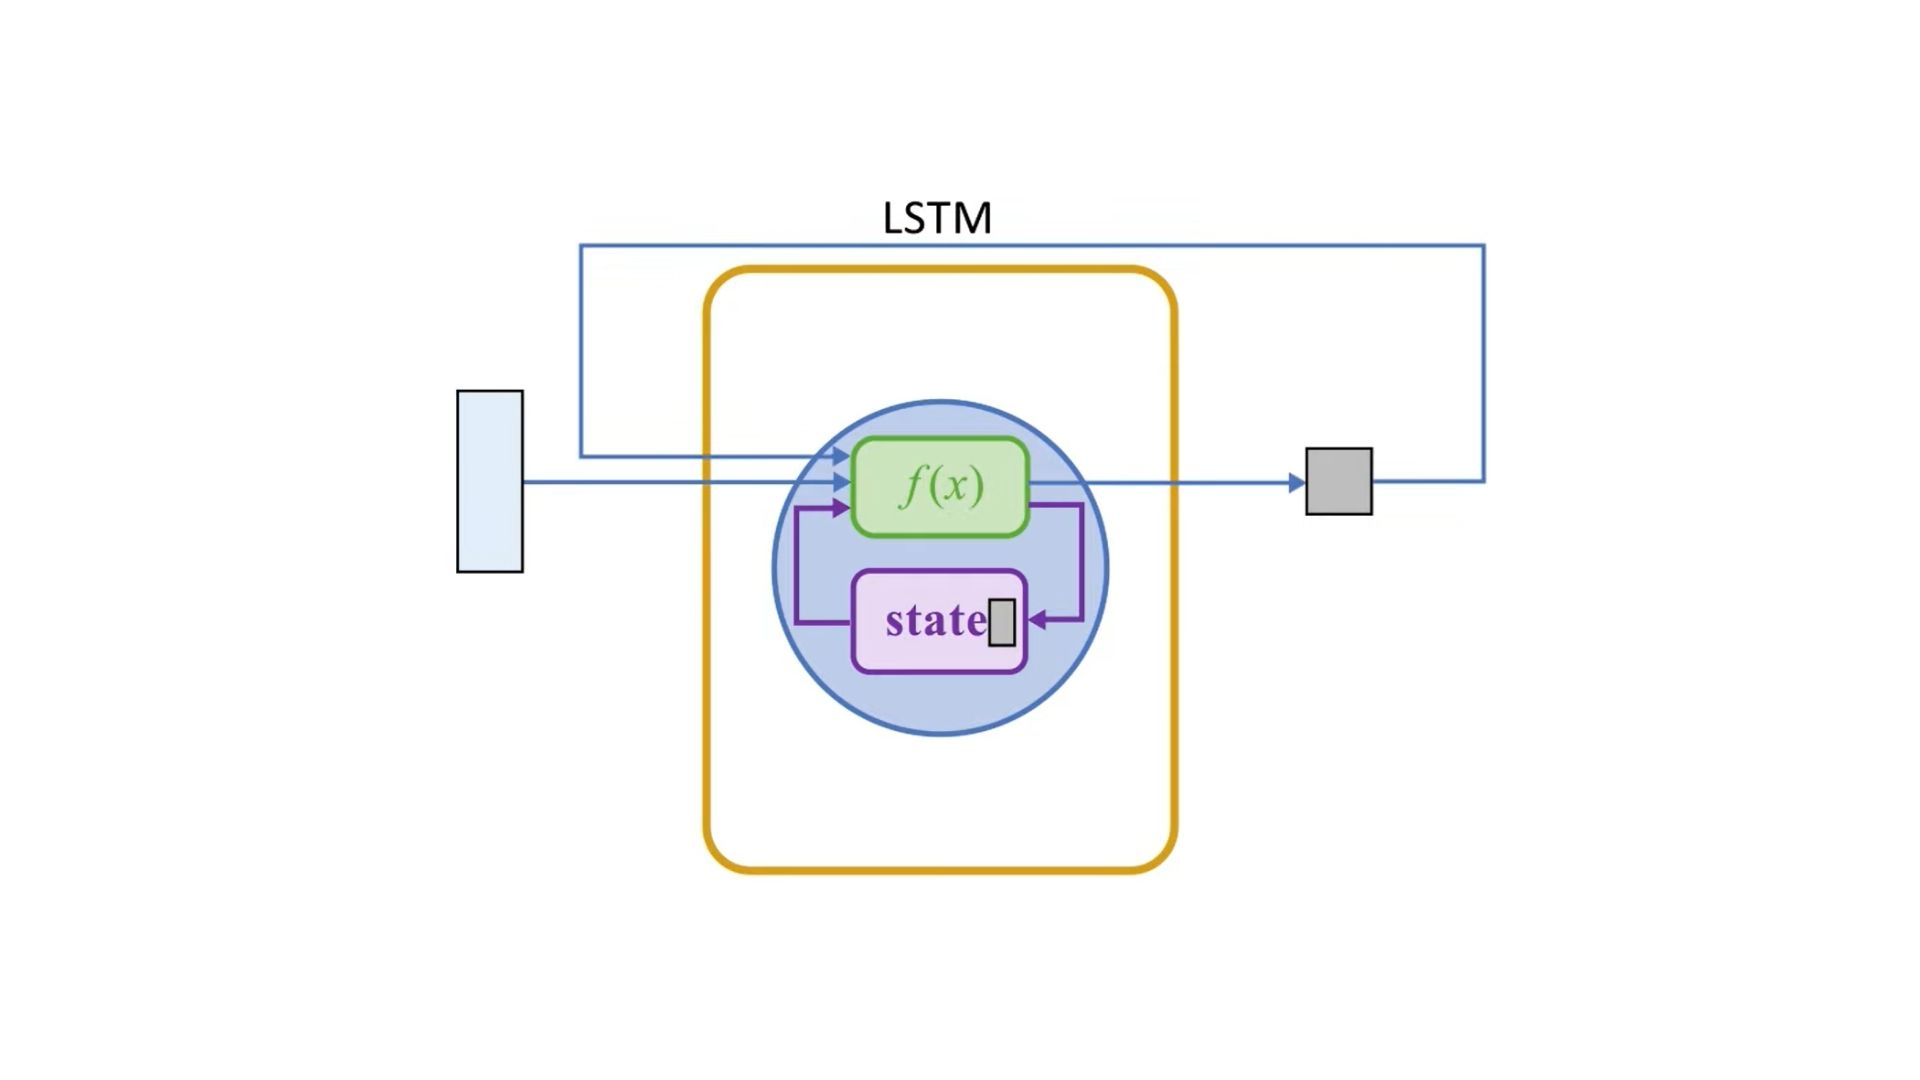

## Gerekli kütüphaneleri içe aktarın

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, Dense

## Genel Amaçlı Fonksiyonlar

- getStockData fonksiyonu, Yahoo Finance'dan hesaplanması istenilen hisse verilerini çeker.

In [2]:
def getStockData(symbol):
    # Hisse senedi verilerini alın
    stock = yf.Ticker(symbol)
    # Tarihsel fiyat verilerini alın
    historical_data = stock.history(period="2y")
    # İndeksi sıfırlayalım
    historical_data.reset_index(inplace=True)

    return historical_data

- str_to_datetime fonksiyonu, string tipine olan tarihi datetime formatına çevirir.

In [3]:
def str_to_datetime(s):
  split = str(s).split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

- df_to_windowed_df fonksiyonu, belirli bir tarih aralığındaki hisse senedi fiyat verilerini kullanarak, hedef tarihteki fiyatı tahmin etmeye yönelik bir "kaydırmalı pencere" (windowed) veri seti oluşturur. Bu, zaman serisi verilerinde kullanılan yaygın bir tekniktir ve özellikle LSTM (Long Short-Term Memory) gibi modellerini eğitmek için kullanılır.

In [4]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date + datetime.timedelta(days=n+3)

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

- windowed_df_to_date_X_y fonksiyonu, kaydırmalı pencere (windowed_dataframe) adlı bir veri çerçevesini, LSTM modeline uygun olan giriş (X) ve çıkış (Y) veri yapılarına dönüştürür. Bu veri çerçevesinin her satırının, belirli bir tarih için geçmiş n kapanış fiyatını ve tahmin edilecek hedef kapanış fiyatını içerdiği varsayılır.

In [5]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)


## Adım 1: Veri setini Yahoo finans kütüphanesinden indirin



In [6]:
symbol = "DOAS.IS"
historical_data = getStockData(symbol)
historical_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2023-01-03 00:00:00+03:00,146.030618,146.785298,139.691309,140.295044,1795253,0.0,0.0
1,2023-01-04 00:00:00+03:00,140.295040,142.785487,137.427264,139.313965,1531087,0.0,0.0
2,2023-01-05 00:00:00+03:00,139.615828,141.125188,128.899372,136.597107,1316451,0.0,0.0
3,2023-01-06 00:00:00+03:00,131.691678,134.333059,125.956105,131.767151,2975424,0.0,0.0
4,2023-01-09 00:00:00+03:00,132.370883,134.182123,125.880642,126.333443,1529403,0.0,0.0


In [7]:
historical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype                          
---  ------        --------------  -----                          
 0   Date          499 non-null    datetime64[ns, Europe/Istanbul]
 1   Open          499 non-null    float64                        
 2   High          499 non-null    float64                        
 3   Low           499 non-null    float64                        
 4   Close         499 non-null    float64                        
 5   Volume        499 non-null    int64                          
 6   Dividends     499 non-null    float64                        
 7   Stock Splits  499 non-null    float64                        
dtypes: datetime64[ns, Europe/Istanbul](1), float64(6), int64(1)
memory usage: 31.3 KB


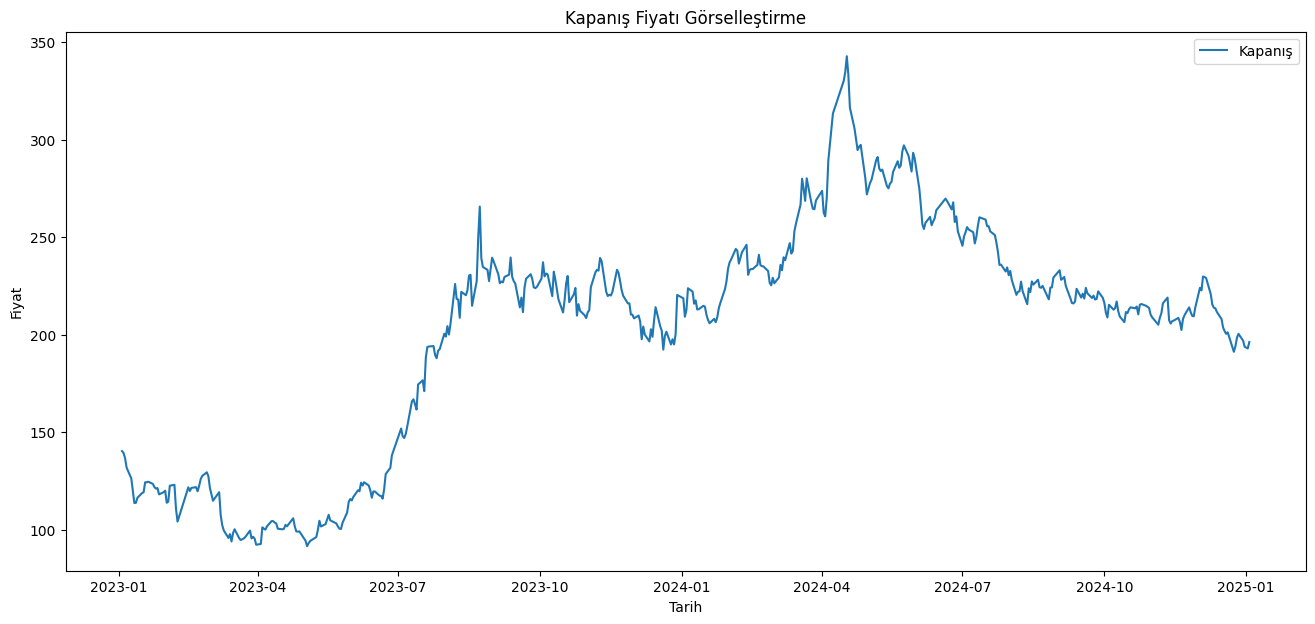

In [8]:
plt.figure(figsize=(16, 7))
plt.title("Kapanış Fiyatı Görselleştirme")
plt.plot(historical_data.Date, historical_data.Close, label='Kapanış')
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.legend(loc='best')
plt.show()

## Adım 2: Veri Ön İşleme

In [9]:
# Alt DataFrame'in bağımsız bir kopyasını oluşturun
df = historical_data[['Date', 'Close']].copy()

# Tarih sütununu datetime formatına dönüştürün
df['Date'] = pd.to_datetime(df['Date'])

# Sadece tarih kısmını alın ve sütunu güncelleyin
df['Date'] = df['Date'].dt.date
df.head()

,Date,Close
0,2023-01-03,140.295044
1,2023-01-04,139.313965
2,2023-01-05,136.597107
3,2023-01-06,131.767151
4,2023-01-09,126.333443


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    499 non-null    object 
 1   Close   499 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.9+ KB


In [11]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date'].head()

,Date
0,2023-01-03
1,2023-01-04
2,2023-01-05
3,2023-01-06
4,2023-01-09


In [12]:
df.index = df.pop('Date')
df.head()

,Close
Date,
2023-01-03,140.295044
2023-01-04,139.313965
2023-01-05,136.597107
2023-01-06,131.767151
2023-01-09,126.333443


### Zaman Serisi Durağanlığı Problemi

LSTM modeli ile çalışırken karşılaşılan en önemli sorunlardan biri, zaman serisi verilerinin durağan olmamasıydı. Model eğitimi sırasında verinin durağan olduğu varsayılır, ancak hisse senedi verileri genellikle trend içerir ve durağan değildir. Bu durum şu sorunlara yol açar:
1. Modelin öğrenme zorluğu
2. Aşırı fiyat dengesizlikleri
3. Tahmin tutarsızlıkları

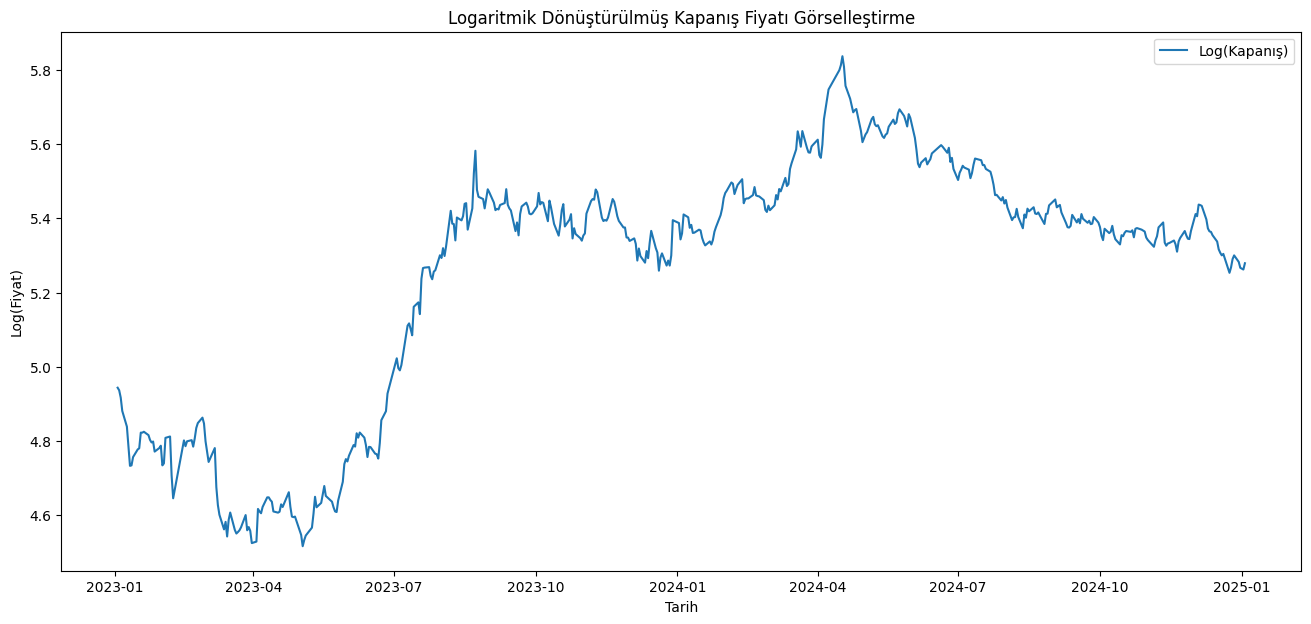

In [13]:
df['Close'] = np.log(df['Close'])

plt.figure(figsize=(16, 7))
plt.title("Logaritmik Dönüştürülmüş Kapanış Fiyatı Görselleştirme")
plt.plot(df.index, df['Close'], label='Log(Kapanış)')
plt.xlabel('Tarih')
plt.ylabel('Log(Fiyat)')
plt.legend(loc='best')
plt.show()

### Min-Max ölçekleme ile verilerin normalize edilmesi

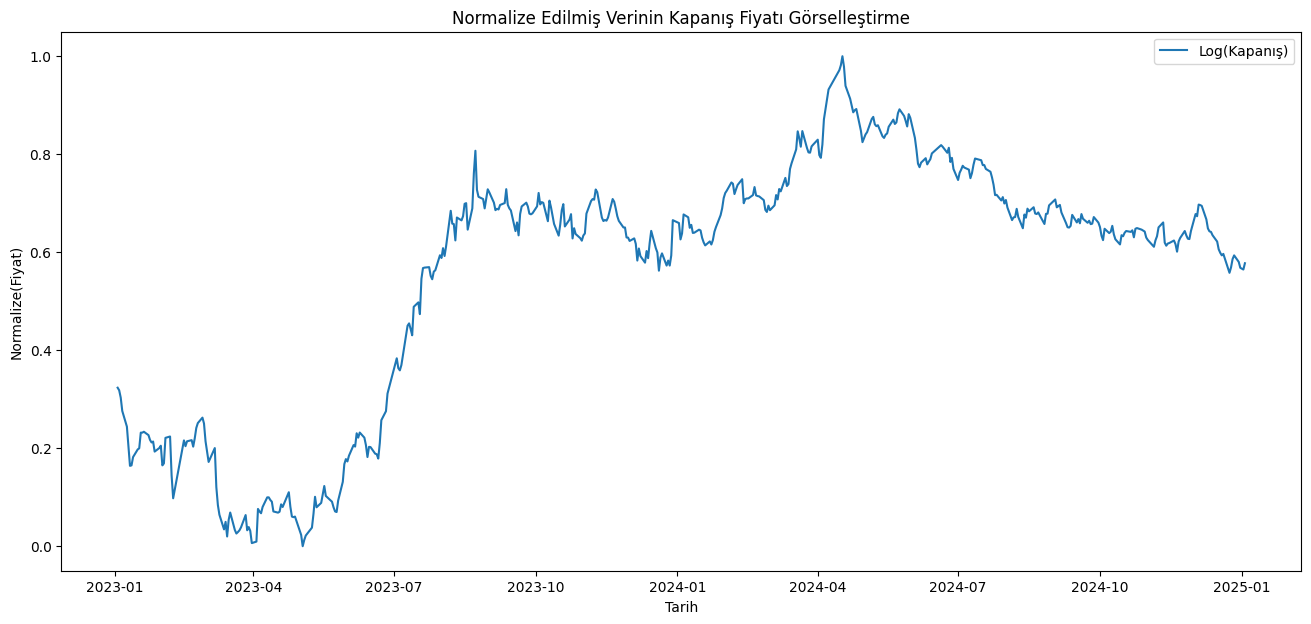

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']].values)
df['Close'] = scaled_data

plt.figure(figsize=(16, 7))
plt.title("Normalize Edilmiş Verinin Kapanış Fiyatı Görselleştirme")
plt.plot(df.index, df['Close'], label='Log(Kapanış)')
plt.xlabel('Tarih')
plt.ylabel('Normalize(Fiyat)')
plt.legend(loc='best')
plt.show()

### Veri Setinin LSTM Yöntemine Uygun Düzenlenmesi

Veri setinde yer alan zaman serisi verilerini pencere (window) tabanlı bir formata dönüştürülür. Böylece, her veri noktasının geçmiş belirli günlerdeki kapanış fiyatlarına göre hedef değeri (bir sonraki kapanış fiyatı) tahmin edilebilecek bir hale geliyor. Daha sonra pencereleme işleminden geçirilmiş verileri dates, X, ve Y şeklinde ayırarak modelin eğitimine uygun hale getirir.

In [15]:
min_date = df.index.min().strftime("%Y-%m-%d")
max_date =  df.index.max().strftime("%Y-%m-%d")

windowed_df = df_to_windowed_df(df,
                                min_date,
                                max_date,
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2023-01-09,0.318184,0.303268,0.276003,0.244109
1,2023-01-10,0.303268,0.276003,0.244109,0.204641
2,2023-01-11,0.276003,0.244109,0.204641,0.164009
3,2023-01-12,0.244109,0.204641,0.164009,0.165014
4,2023-01-13,0.204641,0.164009,0.165014,0.181901
...,...,...,...,...,...
490,2024-12-27,0.557963,0.568974,0.585959,0.593556
491,2024-12-30,0.568974,0.585959,0.593556,0.580211
492,2024-12-31,0.585959,0.593556,0.580211,0.568192
493,2025-01-02,0.593556,0.580211,0.568192,0.564667


In [16]:
dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((495,), (495, 3, 1), (495,))

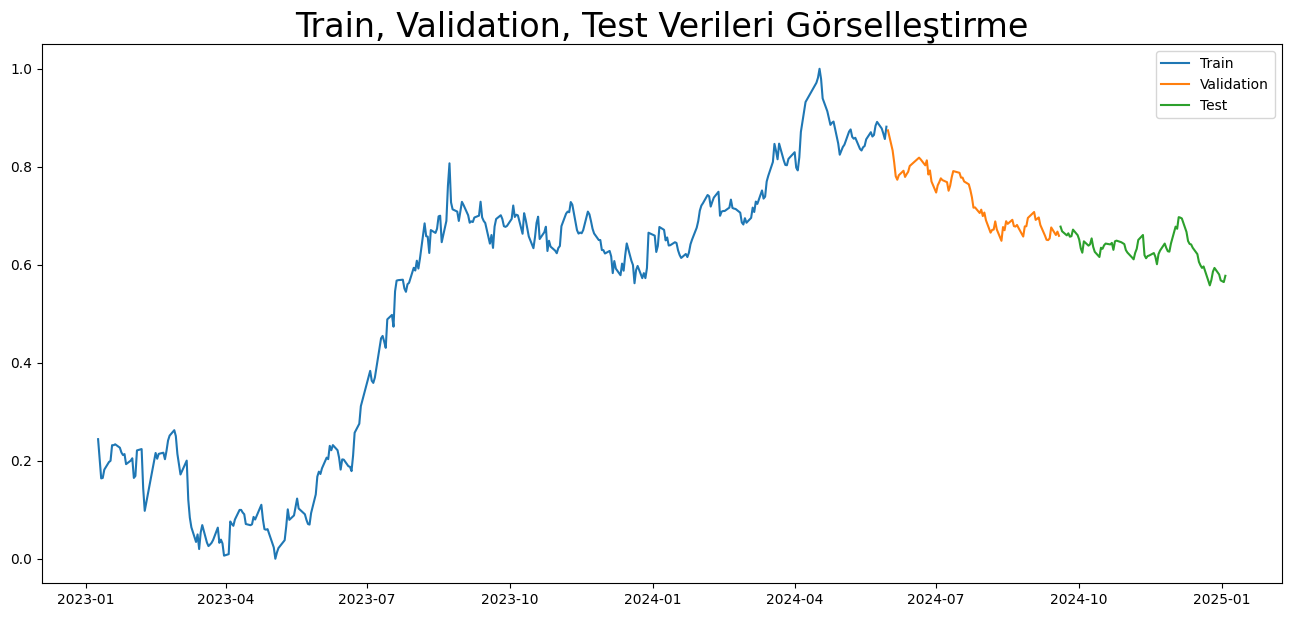

In [17]:
q_70 = int(len(dates) * .7)
q_85 = int(len(dates) * .85)

dates_train, X_train, y_train = dates[:q_70], X[:q_70], y[:q_70]

dates_val, X_val, y_val = dates[q_70:q_85], X[q_70:q_85], y[q_70:q_85]
dates_test, X_test, y_test = dates[q_85:], X[q_85:], y[q_85:]


plt.figure(figsize=(16, 7))
plt.title("Train, Validation, Test Verileri Görselleştirme", fontsize=24)
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

## Adım 3: Modelin Eğitimi ve Geliştirilmesi

### LSTM Model Yapısı

Projede, zaman serisi analizinde etkin bir model olan LSTM (Long Short-Term Memory) tercih edilmiştir. LSTM'in seçilme nedenleri:
- Uzun vadeli bağımlılıkları öğrenebilme kapasitesi
- Geçmiş verilerdeki örüntüleri yakalayabilme yeteneği
- Kapı mekanizmaları sayesinde önemli bilgileri uzun süre hafızada tutabilme

### Model Mimarisi

1. Giriş Katmanı (Input Layer)
  - Giriş boyutu: (3, 1)
  - Zaman serisi verisinde 3 zaman adımı (time steps) ve her adımda 1 özellik var.
  - Bu katman, modelin giriş verisini belirler.

2. LSTM Katmanı
  - LSTM (Long Short-Term Memory): Zaman serisi verilerindeki sıralı bağımlılıkları öğrenir.
  - Çıkış boyutu: 64 nöron içerir. LSTM, zaman serisindeki geçmiş bilgileri saklayarak gelecek tahminler için kullanır.

3. Tam Bağlantılı Katman (Dense Layer)
  - Çıkış boyutu: 32
  - Aktivasyon fonksiyonu: ReLU (Rectified Linear Unit)
    - Modelin doğrusal olmayan ilişkileri öğrenmesini sağlar.

4. İkinci Tam Bağlantılı Katman
  - Çıkış boyutu: 32
  - İkinci bir ReLU katmanı daha eklenmiş, bu da modelin daha karmaşık ilişkileri öğrenmesine olanak tanır.

5. Çıkış Katmanı (Output Layer)
  - Çıkış boyutu: 1 (tek bir değer üretilir).


### Hata Fonksiyonu (Loss Function):
- mse (Mean Squared Error): Tahminler ile gerçek değerler arasındaki hata karelerinin ortalamasını minimize eder.

### Optimizasyon Algoritması:
- Adam (Adaptive Moment Estimation):
- Öğrenme oranı: 0.001
- Hızlı ve etkili bir optimizasyon algoritmasıdır.

### Değerlendirme Metrikleri:
- mean_absolute_error (MAE):
- Modelin tahminleri ile gerçek değerler arasındaki farkların mutlak değerlerinin ortalaması.

In [18]:
model = Sequential([layers.Input((3, 1)), # Giriş Katmanı (Input Layer)
                    layers.LSTM(64), # LSTM Katmanı - 64 Nöron vardır
                    layers.Dense(32, activation='relu'), # Tam bağlantılı katman. Çıkış boyutu 32.
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', # Hata fonksiyonu : mean squared error
              optimizer=Adam(learning_rate=0.001), # Modelin ağırlıklarını güncellemek için Adam optimizasyon algoritması
              metrics=['mean_absolute_error']) # değerlendirme metriği

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20)

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.3191 - mean_absolute_error: 0.4983 - val_loss: 0.3594 - val_mean_absolute_error: 0.5974
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2043 - mean_absolute_error: 0.3870 - val_loss: 0.1652 - val_mean_absolute_error: 0.4044
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0780 - mean_absolute_error: 0.2378 - val_loss: 0.0057 - val_mean_absolute_error: 0.0707
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0195 - mean_absolute_error: 0.1122 - val_loss: 0.0036 - val_mean_absolute_error: 0.0568
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0186 - mean_absolute_error: 0.1074 - val_loss: 0.0073 - val_mean_absolute_error: 0.0821
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0124 - mean_absolute_error: 0.0983 - val_loss: 0.0024 - val_mean_absolute_error: 0.0438
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0088 - mean_absolute_error: 0.0718 - val_loss: 3.66

## Adım 4: Modelin Değerlendirilmesi

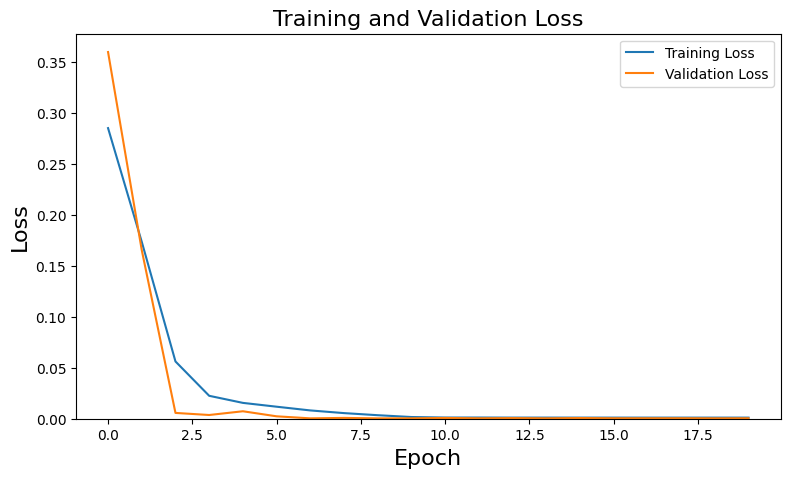

In [19]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)
plt.show()

In [20]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))

y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

train_predict = np.exp(train_predict)
test_predict = np.exp(test_predict)

y_train = np.exp(y_train)
y_test = np.exp(y_test)



val_predictions = model.predict(X_val).flatten()

val_predictions = scaler.inverse_transform(val_predictions.reshape(-1, 1))
val_predictions = np.exp(val_predictions)

y_val = scaler.inverse_transform(y_val.reshape(-1, 1))
y_val = np.exp(y_val)



11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [21]:
# Train RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))

# Test RMSE
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 8.717796136778025
Test RMSE: 5.052770236271077


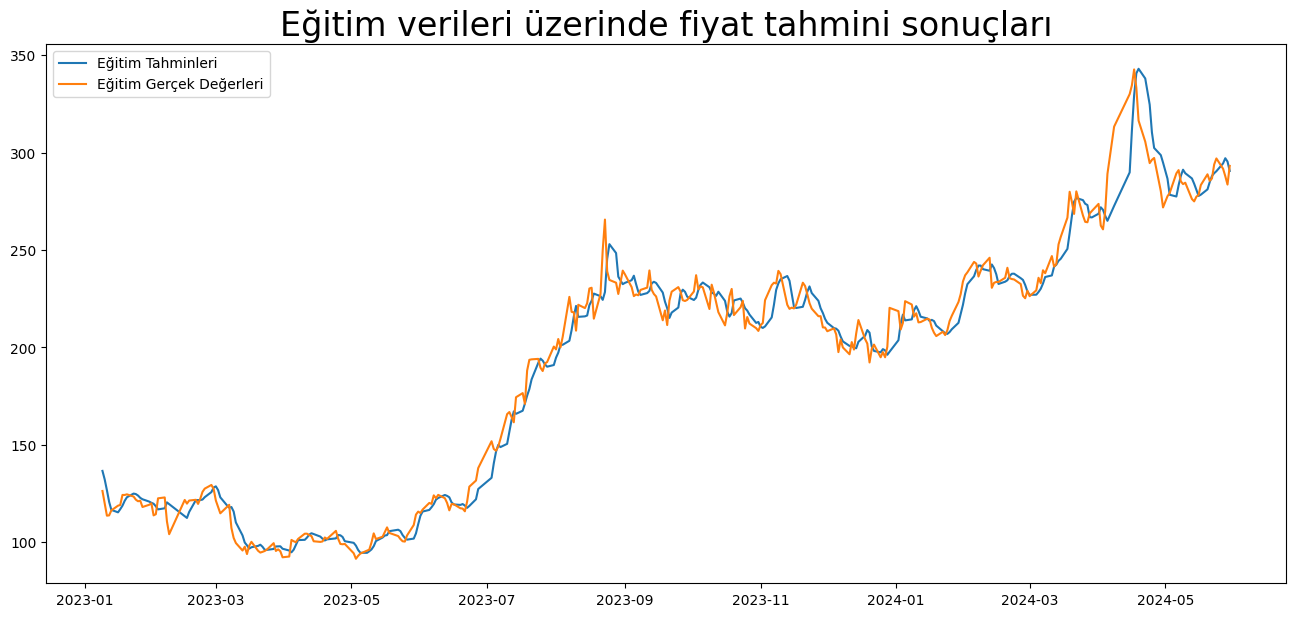

In [22]:
plt.figure(figsize=(16, 7))
plt.title('Eğitim verileri üzerinde fiyat tahmini sonuçları', fontsize=24)
plt.plot(dates_train, train_predict)
plt.plot(dates_train, y_train)
plt.legend(['Eğitim Tahminleri', 'Eğitim Gerçek Değerleri'])

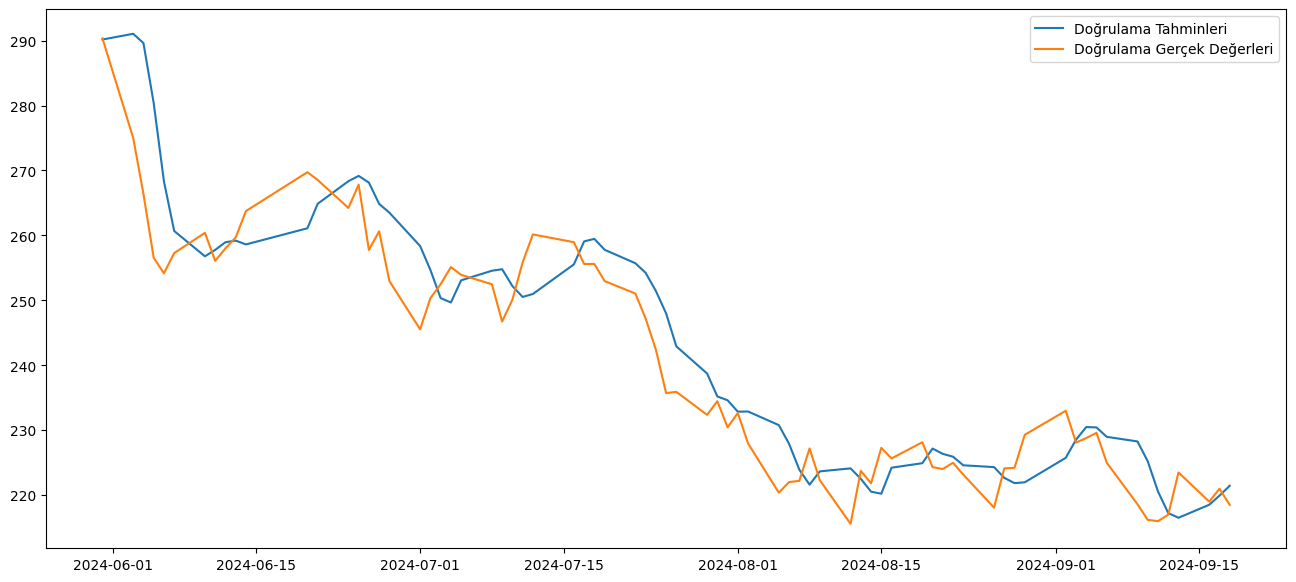

In [23]:
plt.figure(figsize=(16, 7))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Doğrulama Tahminleri', 'Doğrulama Gerçek Değerleri'])

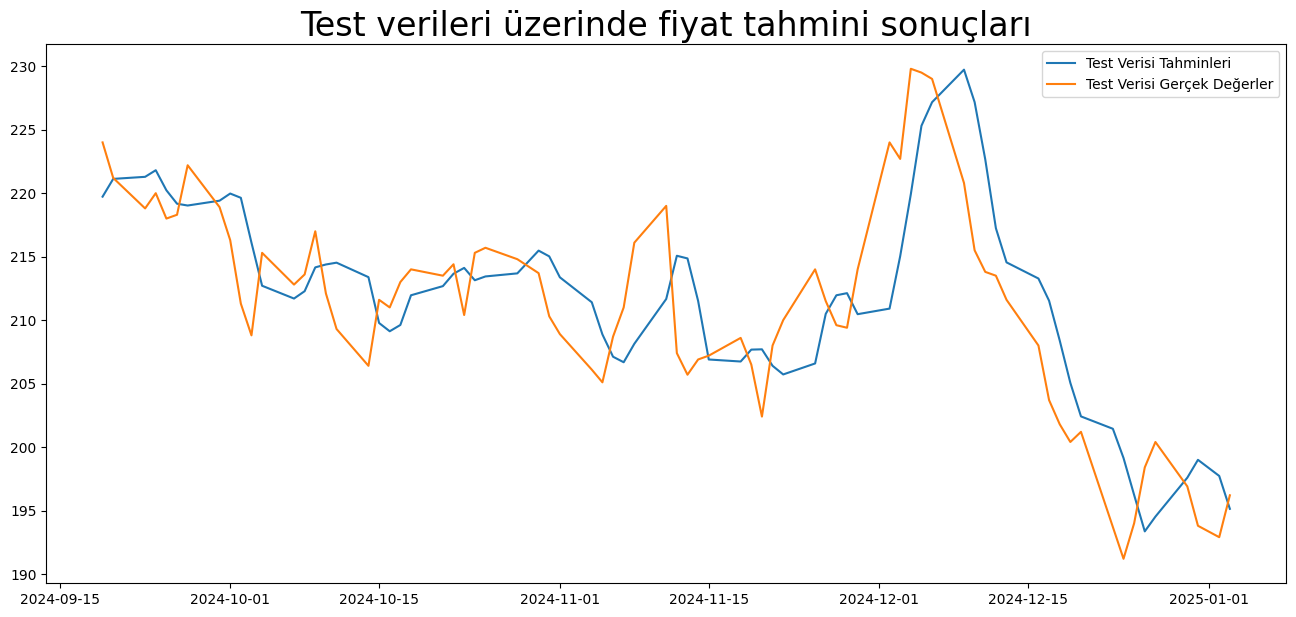

In [24]:
plt.figure(figsize=(16, 7))
plt.title('Test verileri üzerinde fiyat tahmini sonuçları', fontsize=24)
plt.plot(dates_test, test_predict)
plt.plot(dates_test, y_test)
plt.legend(['Test Verisi Tahminleri', 'Test Verisi Gerçek Değerler'])

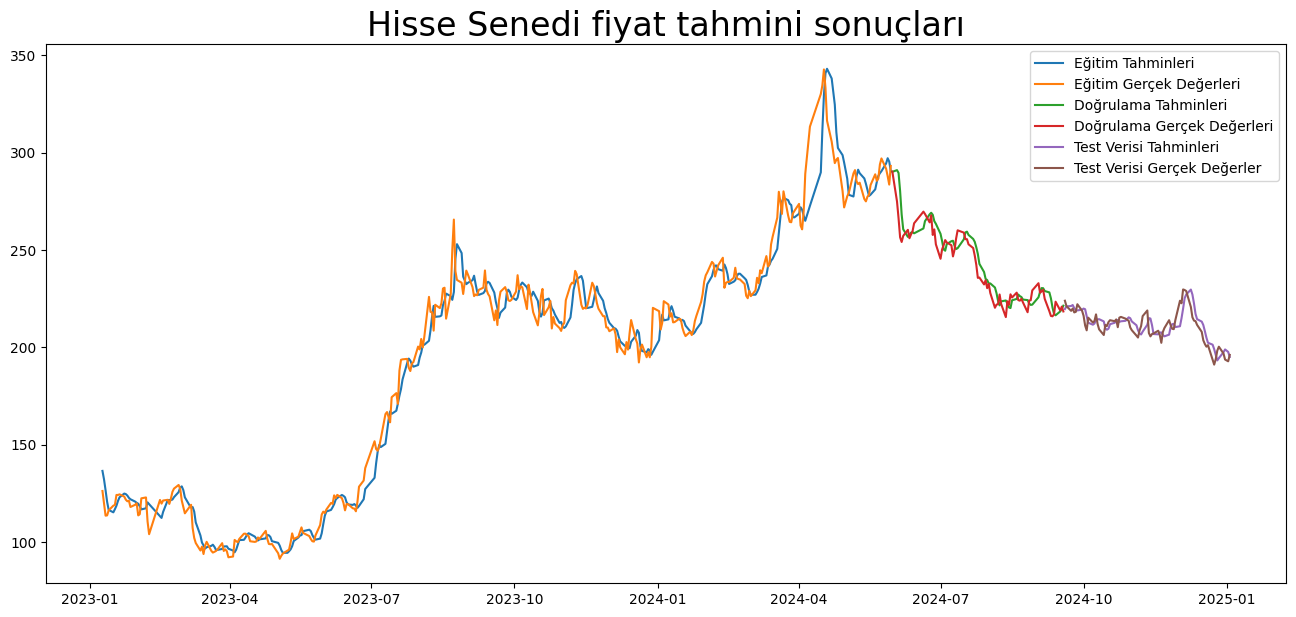

In [25]:
plt.figure(figsize=(16, 7))
plt.title('Hisse Senedi fiyat tahmini sonuçları', fontsize=24)
plt.plot(dates_train, train_predict)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predict)
plt.plot(dates_test, y_test)
plt.legend(['Eğitim Tahminleri',
            'Eğitim Gerçek Değerleri',
            'Doğrulama Tahminleri',
            'Doğrulama Gerçek Değerleri',
            'Test Verisi Tahminleri',
           'Test Verisi Gerçek Değerler'])

# Adım 5: Gelecek Fiyat Tahmini

In [26]:
# Son 3 günlük veriyi kullanarak gelecek 30 gün için tahmin yapalım.
future_predictions = []
last_window = X_test[-1]  # Son 3 günlük veri
for i in range(30):
    prediction = model.predict(last_window.reshape(1, 3, 1))
    future_predictions.append(prediction[0][0])
    last_window = np.append(last_window[1:], prediction) # Kayan pencereyi güncelle
    last_window = last_window.reshape(3, 1)

future_predictions = np.array(future_predictions).reshape(-1,1)
future_predictions = scaler.inverse_transform(future_predictions)
future_predictions = np.exp(future_predictions)

# Gelecek tarihleri oluşturun
last_date = dates_test[-1]
future_dates = [last_date + pd.Timedelta(days=i) for i in range(1,31)]



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

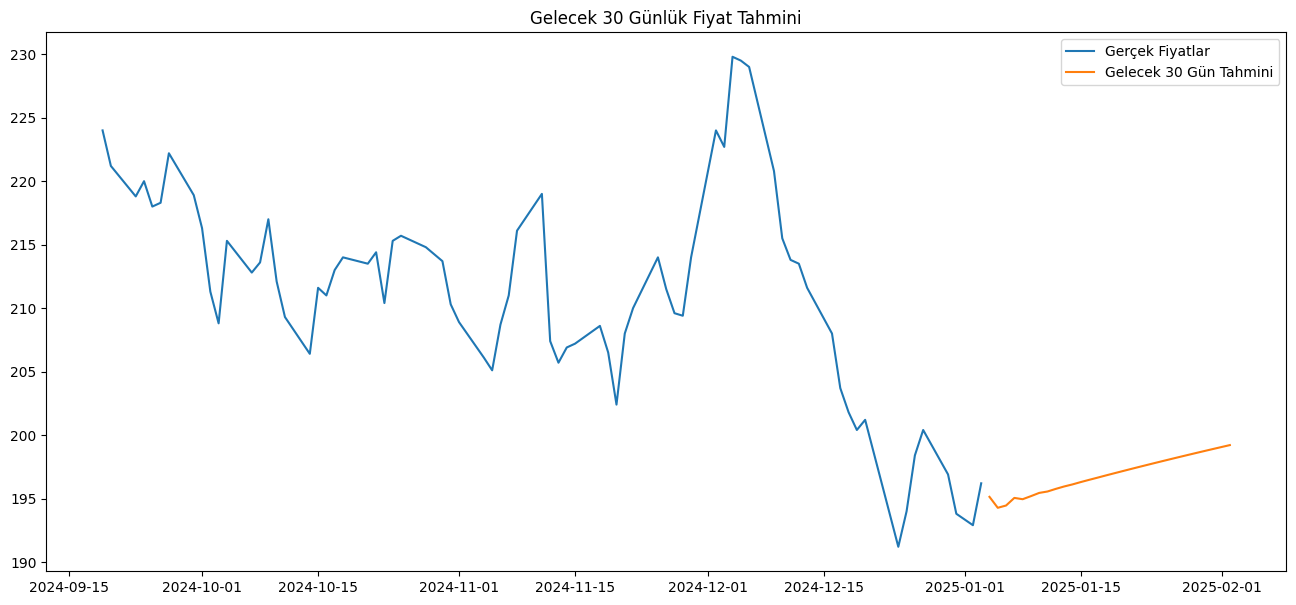

In [27]:
plt.figure(figsize=(16, 7))
plt.plot(dates_test, y_test)
plt.plot(future_dates, future_predictions)
plt.legend(['Gerçek Fiyatlar', 'Gelecek 30 Gün Tahmini'])
plt.title('Gelecek 30 Günlük Fiyat Tahmini')
plt.show()